### Imports

In [1]:
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import numpy as np
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
import pickle
from glob import glob
import cv2
import random
from keras.callbacks import ModelCheckpoint
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import axes3d

Using TensorFlow backend.


In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

### Variables

In [3]:
mapping_numbers_variables = {0:'right_shoulder',
                             1:'right_elbow',
                             2:'right_wrist',
                             3:'left_shoulder',
                             4:'left_elbow',
                             5:'left_wrist'}


columns_df_2D_interest = ['RightShoulder_2D','RightShoulder_2D.1',
                          'RightElbow_2D', 'RightElbow_2D.1',
                          'RightHand_2D','RightHand_2D.1',
                          'LeftShoulder_2D','LeftShoulder_2D.1',
                          'LeftElbow_2D', 'LeftElbow_2D.1', 
                          'LeftHand_2D','LeftHand_2D.1']

columns_df_3D_interest = ['RightShoulder','RightShoulder.1','RightShoulder.2',
                          'RightElbow', 'RightElbow.1','RightElbow.2',
                          'RightHand','RightHand.1','RightHand.2',
                          'LeftShoulder','LeftShoulder.1','LeftShoulder.2',
                          'LeftElbow', 'LeftElbow.1', 'LeftElbow.2',
                          'LeftHand','LeftHand.1','LeftHand.2']

total_num_2Dcoordinates = len(mapping_numbers_variables)*2
total_num_3Dcoordinates = len(mapping_numbers_variables)*3

model = keras.models.load_model('../solutions/Martinez/models/Non_Gravity/noise_lvl1/model.h5')
scaler_2d = pickle.load(open('../solutions/Martinez/models/Non_Gravity/noise_lvl1/scaler_2D.pkl','rb'))
scaler_3d = pickle.load(open('../solutions/Martinez/models/Non_Gravity/noise_lvl1/scaler_3D.pkl','rb'))

D:\Users\rlope\anaconda3\envs\RBT_env\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


### Functions 

In [4]:
def split_3_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 3
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/3)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+3
        output.append(frame_coordinates)
    return(output)

def compute_mpjpe(df_mocap_2D, df_mocap_3D): 
    
    df_mocap_3D = df_mocap_3D[df_mocap_3D['RightHand']<0.2]
    df_mocap_3D = df_mocap_3D[df_mocap_3D['RightHand.1']<0.2]
    df_mocap_3D = df_mocap_3D[df_mocap_3D['RightHand.2']<1.4]
    df_mocap_3D = df_mocap_3D[df_mocap_3D['LeftHand.1']<0.2]
    df_mocap_3D = df_mocap_3D[df_mocap_3D['LeftHand.2']<1.4]
    df_mocap_2D = df_mocap_2D.iloc[df_mocap_3D.index]
    
    df_mocap_2D = scaler_2d.transform(np.array(df_mocap_2D))
    df_mocap_3D = scaler_3d.transform(np.array(df_mocap_3D))
    z_predicted = model.predict(np.array(df_mocap_2D))
    
    df_pred_3d = pd.DataFrame(split_3_coordinates(z_predicted)).rename(columns=mapping_numbers_variables)
    df_gt_3d = pd.DataFrame(split_3_coordinates(np.array(df_mocap_3D))).rename(columns=mapping_numbers_variables)
    df_gt_3d_notScaled = pd.DataFrame(split_3_coordinates(np.array(df_mocap_3D)*scaler_3d.scale_+scaler_3d.mean_)).rename(columns=mapping_numbers_variables)
    
    #Compute the euclidean distances of each 3D predicted keypoint vs the ground truth and generate a dataframe with the results.
    all_distances = []
    for keypoint in list(mapping_numbers_variables.values()):
        keypoint_distances = []
        for i in range(0,len(df_gt_3d[keypoint])):    
            keypoint_distances.append(distance.euclidean(df_gt_3d[keypoint][i], df_pred_3d[keypoint][i]))
        all_distances.append(keypoint_distances)

    df_PJPE = pd.DataFrame(all_distances).T
    means = []
    for column in list(df_PJPE.columns):
        means.append(df_PJPE[column].mean())

    mpjpe = sum(means)/len(df_PJPE.columns)
    return(df_mocap_3D, df_pred_3d, z_predicted, df_gt_3d_notScaled, df_PJPE)

def error_density_plot(df_mocap_3D, df_gt_3d_notScaled, df_PJPE, wrist_to_analyze, min_PJPE=False):
    
    #df_gt_3d_notScaled = pd.DataFrame(np.array(df_mocap_3D)*scaler_3d.scale_+scaler_3d.mean_)
    #df_gt_3d_notScaled = pd.DataFrame(split_3_coordinates(np.array(df_gt_3d_notScaled))).rename(columns=mapping_numbers_variables)
    
    if wrist_to_analyze == 'right_wrist':
        index = 2
    else:
        index = 5
    
    if min_PJPE == True: 
        df_PJPE = df_PJPE[df_PJPE[index]>0.1]
    
    %matplotlib notebook
    #shoulder_mean_3d_positions = df_gt_3D[['right_shoulder', 'right_shoulder.1','right_shoulder.2','left_shoulder','left_shoulder.1','left_shoulder.2']].mean()
    minima = min(df_PJPE[index].tolist())
    maxima = max(df_PJPE[index].tolist())

    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    cmap = matplotlib.cm.viridis
    mapper = cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.viridis)

    #Mapping values to colors
    colors_good = []
    for v in df_PJPE[index].tolist():
        colors_good.append(mapper.to_rgba(v))

    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(1,1,1, projection='3d')
    #ax1.scatter(np.array(df_gt_3d_notScaled[wrist_to_analyze].tolist())[:,0], np.array(df_gt_3d_notScaled[wrist_to_analyze].tolist())[:,2], np.array(df_gt_3d_notScaled[wrist_to_analyze].tolist())[:,1], alpha=0.6, color= np.array(colors_good))
    ax1.scatter(np.array(df_gt_3d_notScaled.iloc[df_PJPE.index][wrist_to_analyze].tolist())[:,0], np.array(df_gt_3d_notScaled.iloc[df_PJPE.index][wrist_to_analyze].tolist())[:,2], np.array(df_gt_3d_notScaled.iloc[df_PJPE.index][wrist_to_analyze].tolist())[:,1], alpha=0.6, color= np.array(colors_good))
    
    ax1.set_xlabel('x[m]')
    ax1.set_ylabel('z[m]')
    ax1.set_zlabel('y[m]')
    cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
    return(df_PJPE)

class KMeans(): 
    def __init__(self, number_K, n_iter, wrist_to_analyze): 
        self.number_K = number_K 
        self.n_iter = n_iter
        self.wrist_to_analyze = wrist_to_analyze
        self.Output = {}
        self.centroids = np.ones([number_K,3])
        
    def computeKmeans(self, df_to_cluster):
        n = 1 #Number of features
        n_iter = self.n_iter #Number of iterations
        K = self.number_K #Number of clusters
        
        if self.wrist_to_analyze == 'right_wrist':
            wrist_index = 2
            df_to_cluster =  df_to_cluster[[6,7,8]]
        else: 
            wrist_index = 5
            keypoint_index = df_to_cluster[[15,16,17]]
        
        centroids = np.ones([K,3]) #Matrix of ones of dimensions Kx3
        #I want to store K random values from the dataframe in the Centroids array
        #This values will be the initial random centroids 
        
        for i in range(K):  
            index = random.randint(0,len(df_to_cluster)-1)
            new_row = np.array(df_to_cluster.iloc[index])
            centroids[i,:] = new_row
        
        EuclideanDistance = np.zeros([len(df_to_cluster), K])
        
        for i in range(0,EuclideanDistance.shape[0]):
            for k in range(K):
                EuclideanDistance[i,k] = distance.euclidean(df_to_cluster.values[i], centroids[k,:] )
            #Tinc les distàncies de cada data point al centroide. --> EuclideanDistance
        
        #Necessitem reagrupar els data points en funció del cluster. Cada data point assignar-lo al cluster
        #mes proper.

        #Dictionary with cluster number as keys and data points which belong to that cluster as values
        Output = {a:[] for a in np.arange(0,self.number_K)}
        Y = {a:[] for a in np.arange(0,self.number_K)}

        cluster_index = list(pd.DataFrame(EuclideanDistance).idxmin(axis=1))
        for i in range(0,len(pd.DataFrame(EuclideanDistance))):
            Y[cluster_index[i]].append(np.array(df_to_cluster.iloc[i]))

        #Recalculo els centroides com la mitja de les x, y , z dels punts assignats a un mateix centroide
        for k in range(0,K):
            centroids[k][0] = sum(np.array(Y[k])[:,0])/len(np.array(Y[k])[:,0])
            centroids[k][1] = sum(np.array(Y[k])[:,1])/len(np.array(Y[k])[:,1])
            centroids[k][2] = sum(np.array(Y[k])[:,2])/len(np.array(Y[k])[:,2])

        #Repetir el cálculo de las distáncias y la recalculación de centroides hasta que se llegue a converger
        for j in range(0,self.n_iter):
            EuclideanDistance = np.zeros([len(df_to_cluster), K])
            for i in range(0,EuclideanDistance.shape[0]):
                for k in range(K):
                    EuclideanDistance[i,k] = distance.euclidean(df_to_cluster.values[i], centroids[k,:] )

            Y = {a:[] for a in np.arange(0,self.number_K)}
            cluster_index = list(pd.DataFrame(EuclideanDistance).idxmin(axis=1))

            for i in range(0,len(pd.DataFrame(EuclideanDistance))):
                Y[cluster_index[i]].append(np.array(df_to_cluster.iloc[i]))
            for k in range(0,K):
                centroids[k][0] = sum(np.array(Y[k])[:,0])/len(np.array(Y[k])[:,0])
                centroids[k][1] = sum(np.array(Y[k])[:,1])/len(np.array(Y[k])[:,1])
                centroids[k][2] = sum(np.array(Y[k])[:,2])/len(np.array(Y[k])[:,2])
                
            self.Output = Y
            self.centroids = centroids
    def WCSS(self): 
        wcss=0
        for k in range(self.number_K):
            for datapoint in self.Output[k]:
                wcss+=np.sum((datapoint-self.centroids[k])**2)

        return wcss

In [5]:
df_mocap_2D = pd.read_csv('../metrics/test_set/MartinezTestSet/2D_test_set_GT_data.csv').drop(columns=['Unnamed: 0'])
df_mocap_3D = pd.read_csv('../metrics/test_set/MartinezTestSet/3D_test_set_GT_data.csv').drop(columns=['Unnamed: 0'])

# Quantitative results

### Overall density plot for right wrist

<IPython.core.display.Javascript object>


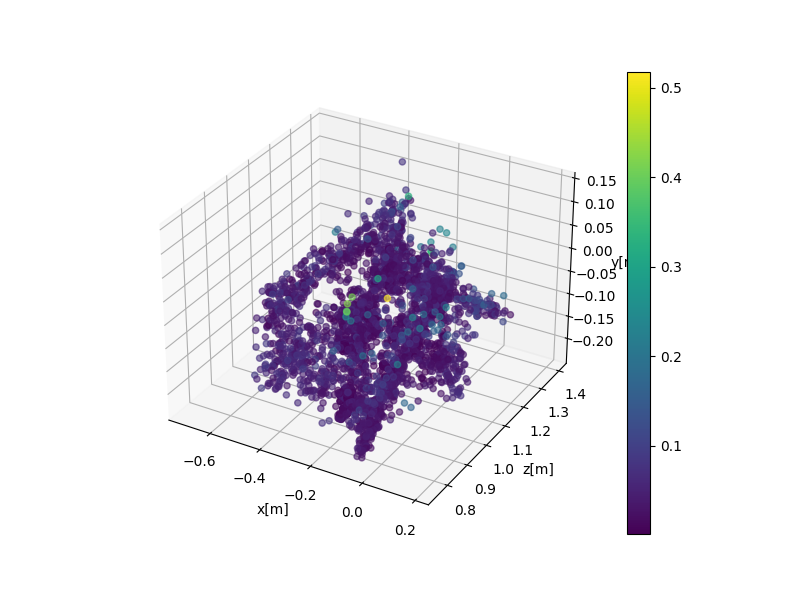

In [6]:
df_mocap_3D, df_pred_3d,z_predicted,df_gt_3d_notScaled, df_PJPE = compute_mpjpe(df_mocap_2D, df_mocap_3D)
df_PJPE = error_density_plot(df_mocap_3D, df_gt_3d_notScaled, df_PJPE, wrist_to_analyze='right_wrist', min_PJPE = False)

### Density plot right wrist euclidean distance < 0.1m

<IPython.core.display.Javascript object>


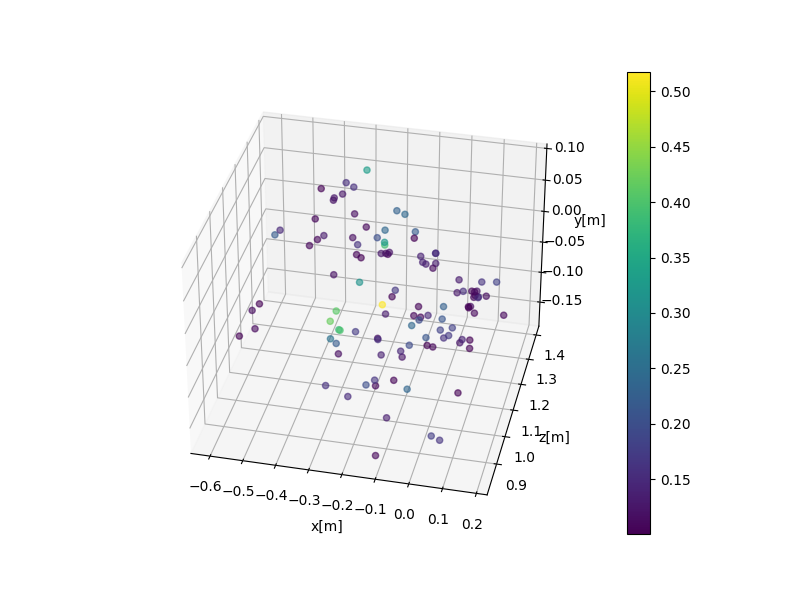

In [7]:
df_PJPE = error_density_plot(df_mocap_3D, df_gt_3d_notScaled, df_PJPE, wrist_to_analyze='right_wrist', min_PJPE = True)

### Elbow method right wrist

In [8]:
df_to_cluster = pd.DataFrame(np.array(df_gt_3d_notScaled.iloc[df_PJPE.index]['right_wrist'].tolist()),columns=[6,7,8])
df_to_cluster.head(5)

WCSS_array=np.array([])
for kn in range(1,6):
    print(kn)
    kmeans2= KMeans(kn, 100, 'right_wrist')
    kmeans2.computeKmeans(df_to_cluster)
    Output, Centroids= kmeans2.Output, kmeans2.centroids
    wcss = kmeans2.WCSS()
    WCSS_array = np.append(WCSS_array, wcss)

1
2
3
4
5


<IPython.core.display.Javascript object>


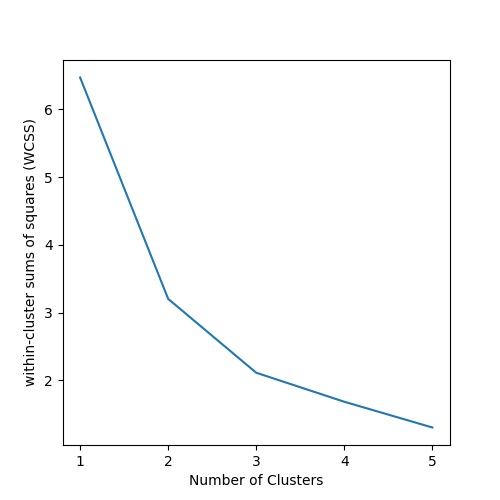

In [9]:
fig = plt.figure(figsize=(5,5))
K_array=np.arange(1,6,1)
plt.plot(K_array,WCSS_array)
plt.xlabel('Number of Clusters')
plt.ylabel('within-cluster sums of squares (WCSS)')
#plt.title('Elbow method to determine optimum number of clusters',fontsize=10)
plt.xticks(ticks=np.arange(1,6,1))
plt.show()

### KMeans algorithm with k clusters selected from elbow method for right wrist

<IPython.core.display.Javascript object>


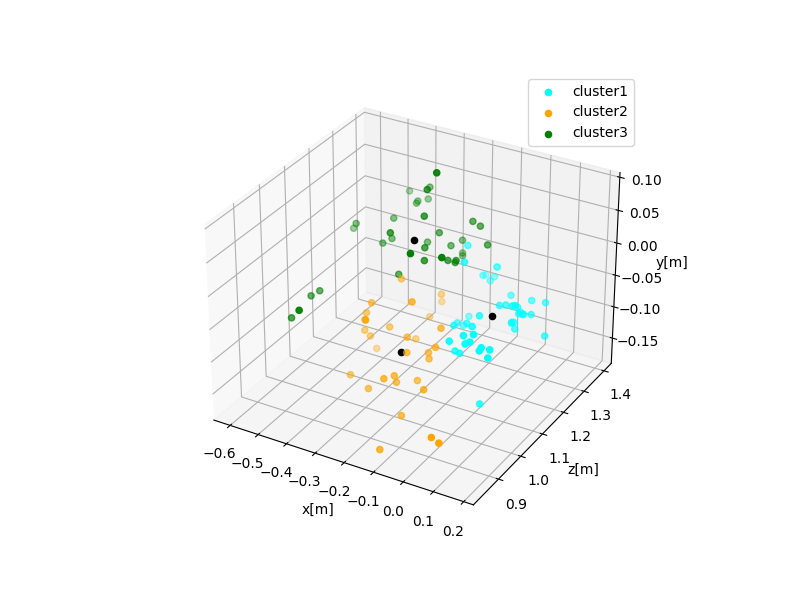

In [8]:
df_to_cluster = pd.DataFrame(np.array(df_gt_3d_notScaled.iloc[df_PJPE.index]['right_wrist'].tolist()),columns=[6,7,8])
df_to_cluster.head(5)

kmeans1 = KMeans(3,100,'right_wrist')
kmeans1.computeKmeans(df_to_cluster=df_to_cluster)

%matplotlib notebook 
color = ['cyan','orange','green','purple','red','blue','magenta', 'yellow']
labels= ['cluster1', 'cluster2','cluster3','cluster4','cluster5', 'cluster6','cluster7']

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1, projection='3d')


for k in range(kmeans1.number_K):
    ax1.scatter(np.array(kmeans1.Output[k])[:,0], np.array(kmeans1.Output[k])[:,2], np.array(kmeans1.Output[k])[:,1], c=color[k], label=labels[k])   
    ax1.scatter(kmeans1.centroids[k][0], kmeans1.centroids[k][2], kmeans1.centroids[k][1], c='black',alpha =1)

ax1.set_xlabel('x[m]')
ax1.set_ylabel('z[m]')
ax1.set_zlabel('y[m]')
ax1.legend()



In [9]:
for k in kmeans1.Output.keys():
    print(len(kmeans1.Output[k]))

45
31
35


### Get the mean error of each cluster 
De les dades dels punts 3D de cada cluster, extreure el seu error i computar la mitja

In [10]:
df_positions_and_error_right_wrist = df_to_cluster.copy()
df_positions_and_error_right_wrist['error'] = df_PJPE[2].values
df_positions_and_error_right_wrist = df_positions_and_error_right_wrist.reset_index().drop(columns=['index'])

cluster_error = []
for cluster in kmeans1.Output.keys(): 
    df_cluster = pd.DataFrame(kmeans1.Output[cluster], columns=[6,7,8])
    #error_cluster = 0
    error_cluster = []
    for i in range(0,len(df_cluster)): 
        error_cluster.append(float(df_positions_and_error_right_wrist.loc[(df_positions_and_error_right_wrist[6] == df_cluster.iloc[i][6]) & (df_positions_and_error_right_wrist[7] == df_cluster.iloc[i][7]) &  (df_positions_and_error_right_wrist[8] == df_cluster.iloc[i][8])]['error']))
    cluster_error.append(error_cluster)    
    #print(error_cluster/len(kmeans1.Output[cluster])*100)

In [11]:
pd.DataFrame(cluster_error).T.mean()*100

0    13.616907
1    20.708296
2    15.686618
dtype: float64

In [12]:
pd.DataFrame(cluster_error).T.std()*100

0     3.419438
1    11.046143
2     7.395351
dtype: float64

### Overall density plot for left wrist

<IPython.core.display.Javascript object>


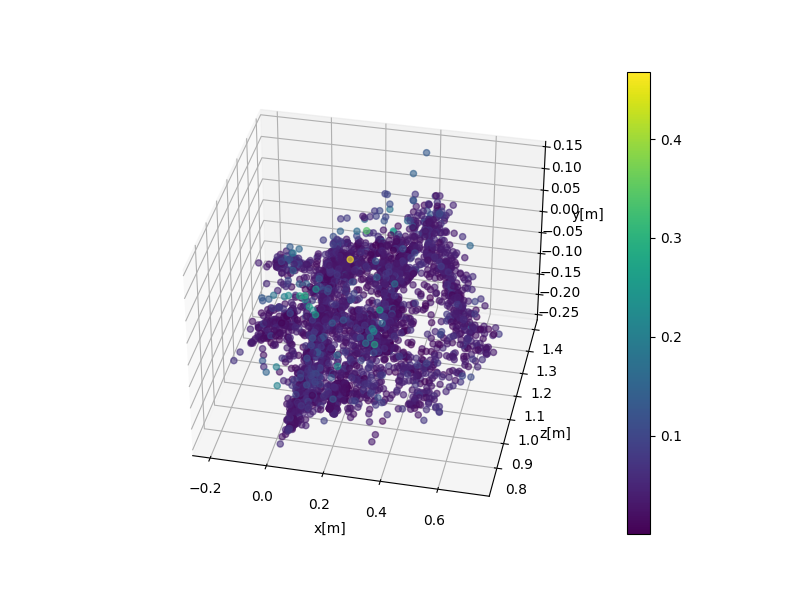

In [13]:
df_mocap_2D = pd.read_csv('../metrics/test_set/MartinezTestSet/2D_test_set_GT_data.csv').drop(columns=['Unnamed: 0'])
df_mocap_3D = pd.read_csv('../metrics/test_set/MartinezTestSet/3D_test_set_GT_data.csv').drop(columns=['Unnamed: 0'])

df_mocap_3D, df_pred_3d,z_predicted,df_gt_3d_notScaled, df_PJPE = compute_mpjpe(df_mocap_2D, df_mocap_3D)
df_PJPE = error_density_plot(df_mocap_3D, df_gt_3d_notScaled, df_PJPE, wrist_to_analyze='left_wrist', min_PJPE = False)

### Density plot right wrist euclidean distance < 0.1m

<IPython.core.display.Javascript object>


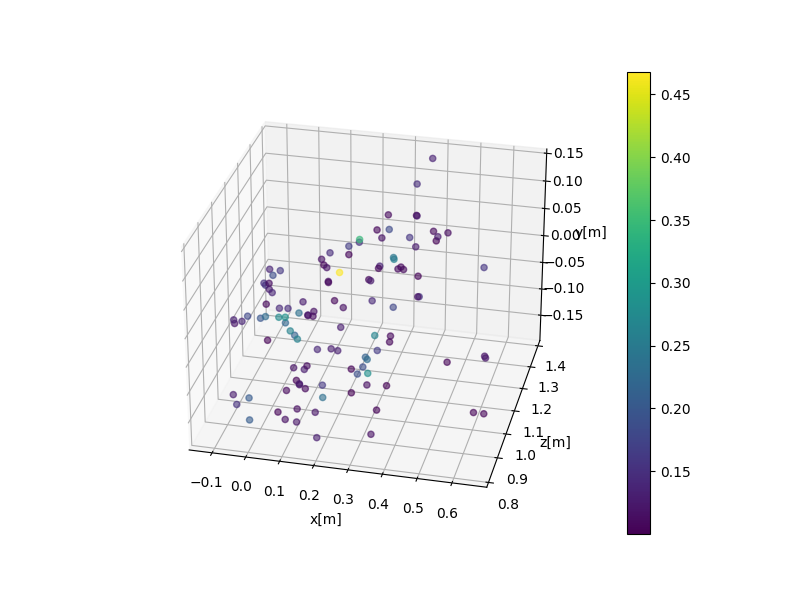

In [14]:
df_PJPE = error_density_plot(df_mocap_3D, df_gt_3d_notScaled, df_PJPE, wrist_to_analyze='left_wrist', min_PJPE = True)

### Elbow method for left wrist 

In [15]:
df_to_cluster = pd.DataFrame(np.array(df_gt_3d_notScaled.iloc[df_PJPE.index]['left_wrist'].tolist()),columns=[15,16,17])
df_to_cluster.head(5)

WCSS_array=np.array([])
for kn in range(1,6):
    print(kn)
    kmeans2= KMeans(kn, 100, 'left_wrist')
    kmeans2.computeKmeans(df_to_cluster)
    Output, Centroids= kmeans2.Output, kmeans2.centroids
    wcss = kmeans2.WCSS()
    WCSS_array = np.append(WCSS_array, wcss)

1
2
3
4
5


<IPython.core.display.Javascript object>


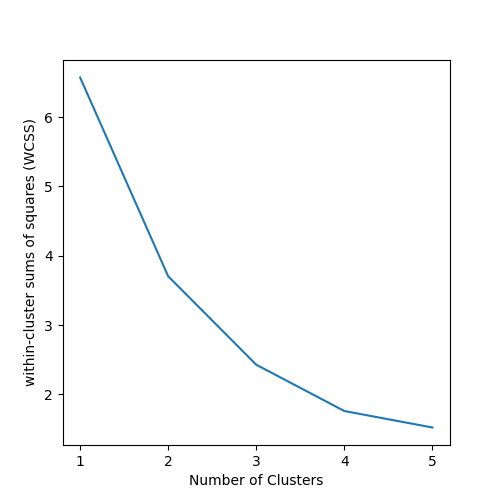

In [16]:
fig = plt.figure(figsize=(5,5))
K_array=np.arange(1,6,1)
plt.plot(K_array,WCSS_array)
plt.xlabel('Number of Clusters')
plt.ylabel('within-cluster sums of squares (WCSS)')
plt.xticks(ticks=np.arange(1,6,1))
plt.show()

### Kmeans clustering for left wrist with K clusters selected from elbow method

<IPython.core.display.Javascript object>


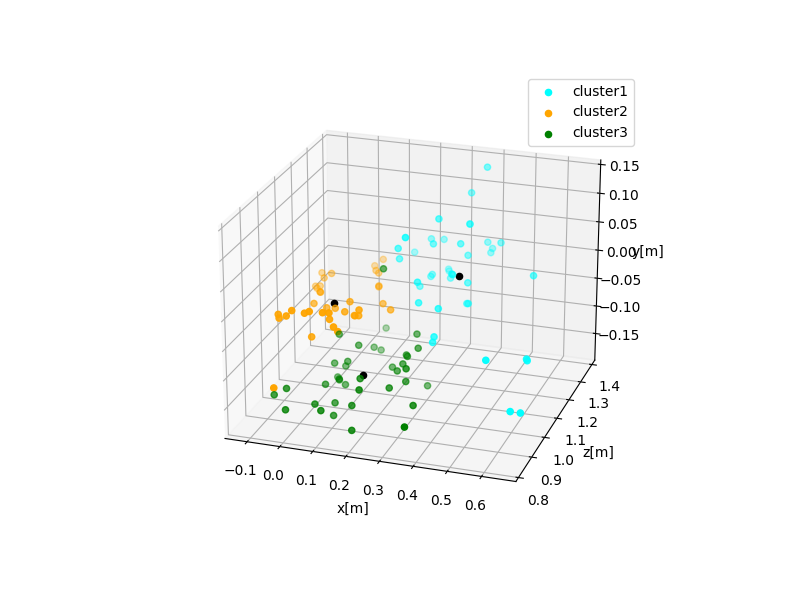

In [17]:
df_to_cluster = pd.DataFrame(np.array(df_gt_3d_notScaled.iloc[df_PJPE.index]['left_wrist'].tolist()),columns=[15,16,17])
df_to_cluster.head(5)

kmeans1 = KMeans(3,100,'left_wrist')
kmeans1.computeKmeans(df_to_cluster=df_to_cluster)

%matplotlib notebook 
color = ['cyan','orange','green','purple','red','blue','magenta', 'yellow']
labels= ['cluster1', 'cluster2','cluster3','cluster4','cluster5', 'cluster6','cluster7']

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1, projection='3d')


for k in range(kmeans1.number_K):
    ax1.scatter(np.array(kmeans1.Output[k])[:,0], np.array(kmeans1.Output[k])[:,2], np.array(kmeans1.Output[k])[:,1], c=color[k], label=labels[k])   
    ax1.scatter(kmeans1.centroids[k][0], kmeans1.centroids[k][2], kmeans1.centroids[k][1], c='black',alpha =1)

ax1.set_xlabel('x[m]')
ax1.set_ylabel('z[m]')
ax1.set_zlabel('y[m]')
ax1.legend()



In [18]:
i = 1
for key in kmeans1.Output.keys():
    print('Cluster number: ' +str(i)+' has: '+str(len(kmeans1.Output[key]))+' data points')
    i+=1

Cluster number: 1 has: 40 data points
Cluster number: 2 has: 38 data points
Cluster number: 3 has: 38 data points


In [23]:
df_positions_and_error_left_wrist = df_to_cluster.copy()
df_positions_and_error_left_wrist['error'] = df_PJPE[5].values
df_positions_and_error_left_wrist = df_positions_and_error_left_wrist.reset_index().drop(columns=['index'])

all_clusters_error= []
for cluster in kmeans1.Output.keys(): 
    df_cluster = pd.DataFrame(kmeans1.Output[cluster], columns=[15,16,17])
    error_cluster = 0
    error_cluster = []
    for i in range(0,len(df_cluster)): 
        error_cluster.append(float(df_positions_and_error_left_wrist.loc[(df_positions_and_error_left_wrist[15] == df_cluster.iloc[i][15]) & (df_positions_and_error_left_wrist[16] == df_cluster.iloc[i][16]) &  (df_positions_and_error_left_wrist[17] == df_cluster.iloc[i][17])]['error']))
    #print(error_cluster/len(kmeans1.Output[cluster])*100)
    all_clusters_error.append(error_cluster)

In [32]:
pd.DataFrame(all_clusters_error).T.mean()*100

0    13.640946
1    15.272813
2    15.762020
dtype: float64

In [33]:
pd.DataFrame(all_clusters_error).T.std()*100

0    4.949951
1    5.119349
2    7.321710
dtype: float64

# Qualitative results

### Random predictions - (Good ones)


<IPython.core.display.Javascript object>


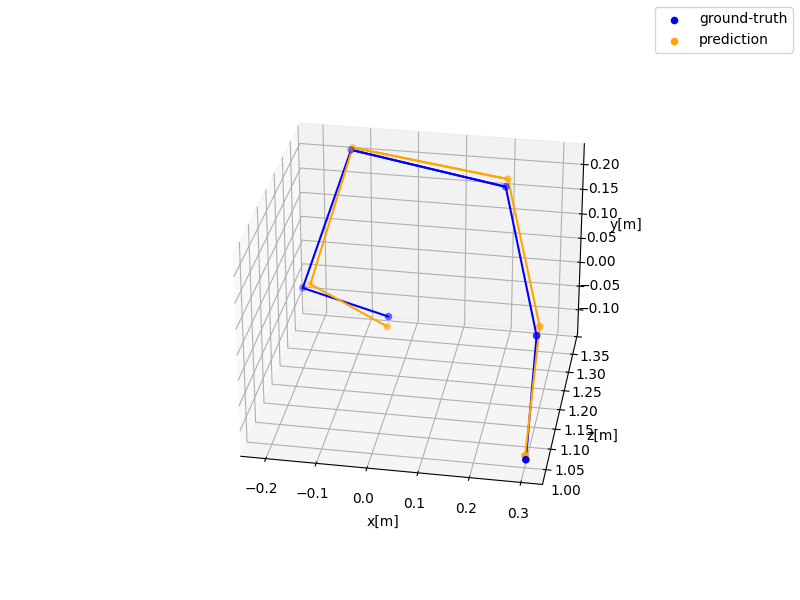

In [135]:
index_bad_predictions = df_PJPE[(df_PJPE[0]>0.1) & (df_PJPE[1]>0.1)& (df_PJPE[2]>0.1)& (df_PJPE[3]>0.1)& (df_PJPE[4]>0.1) & (df_PJPE[5]>0.1)].index.tolist()

rand_index = random.randint(0,len(df_mocap_3D))
while rand_index in index_bad_predictions:
    rand_index = random.randint(0,len(df_mocap_3D))
    
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1, projection='3d')

x_gt = np.array(split_3_coordinates(np.array(pd.DataFrame(df_mocap_3D*scaler_3d.scale_+scaler_3d.mean_)))[rand_index])[:,0].tolist()
y_gt = np.array(split_3_coordinates(np.array(pd.DataFrame(df_mocap_3D*scaler_3d.scale_+scaler_3d.mean_)))[rand_index])[:,1].tolist()
z_gt = np.array(split_3_coordinates(np.array(pd.DataFrame(df_mocap_3D*scaler_3d.scale_+scaler_3d.mean_)))[rand_index])[:,2].tolist()

x_pred = np.array(split_3_coordinates(np.array(pd.DataFrame(z_predicted*scaler_3d.scale_+scaler_3d.mean_)))[rand_index])[:,0].tolist()
y_pred = np.array(split_3_coordinates(np.array(pd.DataFrame(z_predicted*scaler_3d.scale_+scaler_3d.mean_)))[rand_index])[:,1].tolist()
z_pred = np.array(split_3_coordinates(np.array(pd.DataFrame(z_predicted*scaler_3d.scale_+scaler_3d.mean_)))[rand_index])[:,2].tolist()

ax1.scatter(np.array(x_gt), np.array(z_gt), np.array(y_gt), color='blue', label='ground-truth')
ax1.scatter(np.array(x_pred), np.array(z_pred), np.array(y_pred), color='orange',label='prediction')


ax1.set_xlabel('x[m]')
ax1.set_ylabel('z[m]')
ax1.set_zlabel('y[m]')

ax1.plot([x_gt[0], x_gt[3]],[z_gt[0], z_gt[3]],[y_gt[0], y_gt[3]], c='b')
ax1.plot([x_gt[0], x_gt[1]],[z_gt[0], z_gt[1]],[y_gt[0], y_gt[1]], c='b')
ax1.plot([x_gt[1], x_gt[2]],[z_gt[1], z_gt[2]],[y_gt[1], y_gt[2]], c='b')
ax1.plot([x_gt[0], x_gt[3]],[z_gt[0], z_gt[3]],[y_gt[0], y_gt[3]], c='b')
ax1.plot([x_gt[3], x_gt[4]],[z_gt[3], z_gt[4]],[y_gt[3], y_gt[4]], c='b')
ax1.plot([x_gt[4], x_gt[5]],[z_gt[4], z_gt[5]],[y_gt[4], y_gt[5]], c='b')

ax1.plot([x_pred[0], x_pred[3]],[z_pred[0], z_pred[3]],[y_pred[0], y_pred[3]], c='orange')
ax1.plot([x_pred[0], x_pred[1]],[z_pred[0], z_pred[1]],[y_pred[0], y_pred[1]], c='orange')
ax1.plot([x_pred[1], x_pred[2]],[z_pred[1], z_pred[2]],[y_pred[1], y_pred[2]], c='orange')
ax1.plot([x_pred[0], x_pred[3]],[z_pred[0], z_pred[3]],[y_pred[0], y_pred[3]], c='orange')
ax1.plot([x_pred[3], x_pred[4]],[z_pred[3], z_pred[4]],[y_pred[3], y_pred[4]], c='orange')
ax1.plot([x_pred[4], x_pred[5]],[z_pred[4], z_pred[5]],[y_pred[4], y_pred[5]], c='orange')
fig.legend()


<IPython.core.display.Javascript object>


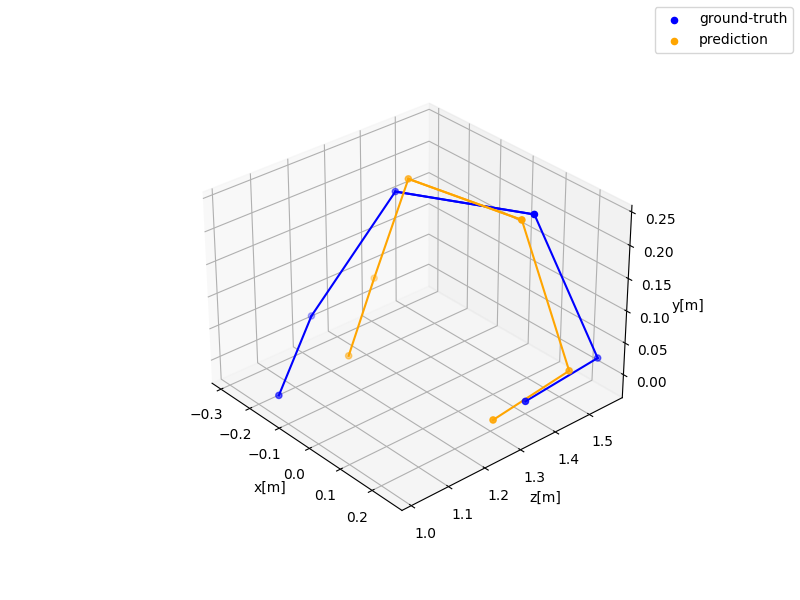

In [145]:

rand_index = 4379
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1, projection='3d')

x_gt = np.array(split_3_coordinates(np.array(pd.DataFrame(df_mocap_3D*scaler_3d.scale_+scaler_3d.mean_)))[rand_index])[:,0].tolist()
y_gt = np.array(split_3_coordinates(np.array(pd.DataFrame(df_mocap_3D*scaler_3d.scale_+scaler_3d.mean_)))[rand_index])[:,1].tolist()
z_gt = np.array(split_3_coordinates(np.array(pd.DataFrame(df_mocap_3D*scaler_3d.scale_+scaler_3d.mean_)))[rand_index])[:,2].tolist()

x_pred = np.array(split_3_coordinates(np.array(pd.DataFrame(z_predicted*scaler_3d.scale_+scaler_3d.mean_)))[rand_index])[:,0].tolist()
y_pred = np.array(split_3_coordinates(np.array(pd.DataFrame(z_predicted*scaler_3d.scale_+scaler_3d.mean_)))[rand_index])[:,1].tolist()
z_pred = np.array(split_3_coordinates(np.array(pd.DataFrame(z_predicted*scaler_3d.scale_+scaler_3d.mean_)))[rand_index])[:,2].tolist()

ax1.scatter(np.array(x_gt), np.array(z_gt), np.array(y_gt), color='blue', label='ground-truth')
ax1.scatter(np.array(x_pred), np.array(z_pred), np.array(y_pred), color='orange',label='prediction')


ax1.set_xlabel('x[m]')
ax1.set_ylabel('z[m]')
ax1.set_zlabel('y[m]')

ax1.plot([x_gt[0], x_gt[3]],[z_gt[0], z_gt[3]],[y_gt[0], y_gt[3]], c='b')
ax1.plot([x_gt[0], x_gt[1]],[z_gt[0], z_gt[1]],[y_gt[0], y_gt[1]], c='b')
ax1.plot([x_gt[1], x_gt[2]],[z_gt[1], z_gt[2]],[y_gt[1], y_gt[2]], c='b')
ax1.plot([x_gt[0], x_gt[3]],[z_gt[0], z_gt[3]],[y_gt[0], y_gt[3]], c='b')
ax1.plot([x_gt[3], x_gt[4]],[z_gt[3], z_gt[4]],[y_gt[3], y_gt[4]], c='b')
ax1.plot([x_gt[4], x_gt[5]],[z_gt[4], z_gt[5]],[y_gt[4], y_gt[5]], c='b')

ax1.plot([x_pred[0], x_pred[3]],[z_pred[0], z_pred[3]],[y_pred[0], y_pred[3]], c='orange')
ax1.plot([x_pred[0], x_pred[1]],[z_pred[0], z_pred[1]],[y_pred[0], y_pred[1]], c='orange')
ax1.plot([x_pred[1], x_pred[2]],[z_pred[1], z_pred[2]],[y_pred[1], y_pred[2]], c='orange')
ax1.plot([x_pred[0], x_pred[3]],[z_pred[0], z_pred[3]],[y_pred[0], y_pred[3]], c='orange')
ax1.plot([x_pred[3], x_pred[4]],[z_pred[3], z_pred[4]],[y_pred[3], y_pred[4]], c='orange')
ax1.plot([x_pred[4], x_pred[5]],[z_pred[4], z_pred[5]],[y_pred[4], y_pred[5]], c='orange')
fig.legend()


In [142]:
index_bad_predictions

[2910, 4045, 4379]

In [86]:
x_gt

[-0.15147596777592895,
 -0.41356456613139364,
 -0.45525392884093824,
 0.28019359996497617,
 0.07740143835181375,
 -0.24945383795179152]

In [75]:
x_gt

[0.18201971562296682,
 0.2709121639258235,
 0.3603800605024991,
 0.35625401898577685,
 0.6687245305905936,
 1.1077611203156885]

In [57]:
np.array(split_3_coordinates(np.array(pd.DataFrame(z_predicted)))[rand_index])

array([[-0.3341874 , -0.43439564, -0.63981414],
       [-0.48167846, -0.50579226, -0.7343314 ],
       [ 0.19539452, -0.480804  , -0.48212546],
       [ 0.21503836, -0.3505734 , -0.52841514],
       [ 0.12585412, -0.5339921 , -0.68121946],
       [-0.22096196, -0.5835826 , -0.6487629 ]], dtype=float32)

In [ ]:
final_axs.plot(np.array(output_list_coords_camera_frame)[:,0][:,0][0:3].tolist(), np.array(output_list_coords_camera_frame)[:,0][:,2][0:3].tolist(), np.array(output_list_coords_camera_frame)[:,0][:,1][0:3].tolist(), color='orange')

In [42]:
np.array(split_3_coordinates(np.array(pd.DataFrame(df_mocap_3D))))[0]


array([[-0.15732677, -0.34518308, -0.62169227],
       [-0.00449859, -0.55647218, -0.73911843],
       [-0.09311244, -0.61220563, -0.82335289],
       [ 0.41476203, -0.40420678, -0.59749372],
       [ 0.1584046 , -0.52407744, -0.90448164],
       [ 0.0441744 , -0.65951555, -0.8776215 ]])

In [34]:
np.array(split_3_coordinates(np.array(pd.DataFrame(df_mocap_3D)))[0])[:,0]

array([-0.15732677, -0.00449859, -0.09311244,  0.41476203,  0.1584046 ,
        0.0441744 ])

In [35]:
np.array(split_3_coordinates(np.array(pd.DataFrame(df_mocap_3D)))[0])

array([[-0.15732677, -0.34518308, -0.62169227],
       [-0.00449859, -0.55647218, -0.73911843],
       [-0.09311244, -0.61220563, -0.82335289],
       [ 0.41476203, -0.40420678, -0.59749372],
       [ 0.1584046 , -0.52407744, -0.90448164],
       [ 0.0441744 , -0.65951555, -0.8776215 ]])